## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random

In [3]:
sys.path.insert(0, "../")
from utils.DLutils import *
from utils.vizutils import plot_col_dists
from create_toybrains import ToyBrainsData
from experiments.fit_DL_model import *

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
DEEPREPVIZ_REPO = "../../Deep-confound-control-v2/"
sys.path.append(DEEPREPVIZ_REPO)
from DeepRepViz import *

In [5]:
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger, WandbLogger

In [6]:
import logging
# disable some unneccesary lightning warnings
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

In [7]:
DATASETS = ["../dataset/toybrains_n10000_highsignal",
            "../dataset/toybrains_n10000_midsignal",
            "../dataset/toybrains_n10000_lowsignal"]

In [8]:
dataset_path = DATASETS[0]
unique_name = dataset_path.split('/')[-1].split('_')[-1]
raw_csv_path = glob(f'{dataset_path}/*{unique_name}.csv')[0]

## Generate toybrain datasets 
```bash
$ nohup python3 create_toybrains.py -c configs.lbl1cov1 -n 10000 --suffix n_highsignal &> nohup1.out &
$ nohup python3 create_toybrains.py -c configs.lbl1cov1_midsignal -n 10000 --suffix n_midsignal &>  nohup2.out &
$ nohup python3 create_toybrains.py -c configs.lbl1cov1_lowsignal -n 10000 --suffix n_lowsignal &> nohup3.out &
```

### Generative attr. dist.

In [9]:
# for data_dir in DATASETS:
#     data_name = data_dir.split('/')[-1]
#     df = pd.read_csv(f'{data_dir}/{data_name}.csv')
#     cov_cols = df.filter(regex='^(cov_|lbl_)').columns
#     attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
#     plot_col_dists(df, 
#                    attr_cols=attr_cols, cov_cols=cov_cols, 
#                    title=f"{data_name}: Dist. of generative data attributes vs the labels")
#     plt.show()

### Baseline attr. accuracies

In [10]:
results = []
for data_dir in DATASETS:
    toy = ToyBrainsData("configs.lbl1cov1")
    # load the already generated dataset
    toy.load_generated_dataset(data_dir)
    result = toy.fit_baseline_models(CV=10) 
    results.append(result)

running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000_highsignal


100%|██████████| 70/70 [00:07<00:00,  9.97it/s]


TOTAL RUNTIME: 0:00:08
running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000_midsignal


100%|██████████| 70/70 [00:04<00:00, 16.35it/s]


TOTAL RUNTIME: 0:00:05
running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000_lowsignal


100%|██████████| 70/70 [00:04<00:00, 16.50it/s]


TOTAL RUNTIME: 0:00:05


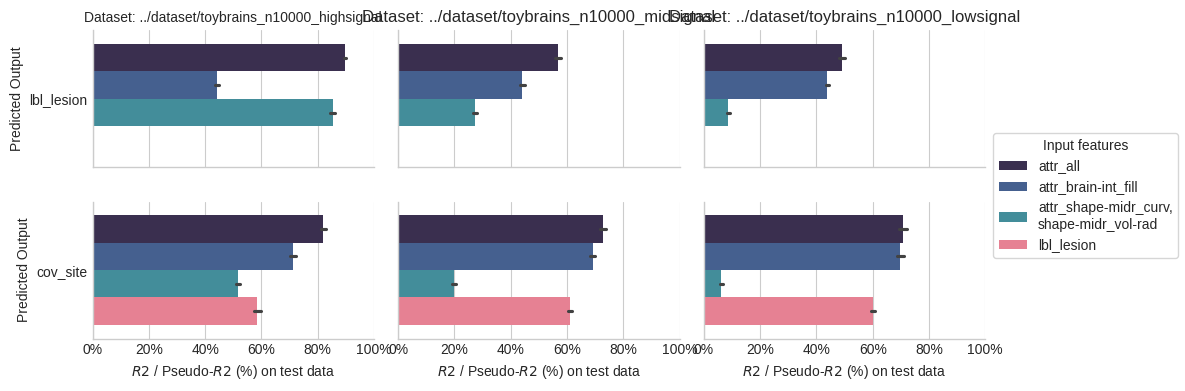

In [11]:
toy.viz_baseline_results(results)

#### collect the results in a df

In [12]:
df_baseline = pd.concat(results)

In [13]:
grp_by_cols = ['dataset', 'inp']
signal_col = 'test_metric'
df_baseline_temp = df_baseline.loc[df_baseline.out.apply(lambda x: 'lbl_' in x).values, grp_by_cols+[signal_col]]

In [14]:
df_baseline_temp = df_baseline_temp.groupby(grp_by_cols).mean().reset_index()
df_baseline_temp.inp = df_baseline_temp.inp.map({'attr_all':r'$BL_{total}$', 
                                                 'attr_shape-midr_curv, shape-midr_vol-rad':r'$BL_{signal}$',
                                                 'attr_brain-int_fill':r'$BL_{conf}$'})

In [15]:
df_final = {}
cols = []
for dataset, dfi in df_baseline_temp.groupby("dataset"):
    dfi = dfi[['inp','test_metric']].T
    dfi.columns = dfi.loc['inp'].values
    dfi = dfi.drop(index='inp')
    if not len(cols): 
        cols = dfi.columns
    vals = [dfi[c].values[0] for c in cols]
    df_final.update({dataset: vals})
    
df_final = pd.DataFrame.from_dict(df_final, orient='index', columns=cols)
df_final.index.name = 'Dataset'
df_final.index = df_final.index.str.replace('../dataset/toybrains_n10000_', '')
df_final.style.bar(vmin=0, vmax=1)

,$BL_{total}$,$BL_{conf}$,$BL_{signal}$
Dataset,,,
highsignal,0.898751,0.442290,0.853524
lowsignal,0.491023,0.439231,0.086265
midsignal,0.569293,0.441084,0.273715


## Fit DL models

In [41]:
debug = True
label = "lbl_lesion"
random_seed=42 if debug else None
batch_size=64

#### select the GPU

In [42]:
# check GPUs available and memory
! gpustat

cuda01                         Fri Nov 10 10:51:18 2023  545.23.06
[0] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |    98 / 11264 MB | gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |    98 / 11264 MB | gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |    98 / 11264 MB | gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |    98 / 11264 MB | gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |    98 / 11264 MB | gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |    98 / 11264 MB | gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |    98 / 11264 MB | gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |    98 / 11264 MB | gdm(4M)


In [43]:
GPUs = [1]

In [44]:
torch.set_float32_matmul_precision('medium')
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
os.environ["TF_ENABLE_ONEDNN_OPTS"]="0"

#### Model config

In [47]:
model_class = SimpleCNN
model_kwargs=dict(num_classes=1, final_act_size=3)


test model init and see model layer names for hook

In [48]:
model = model_class(**model_kwargs)
print(f"pytorch_total_params = {sum(p.numel() for p in model.parameters() if p.requires_grad)})")

pytorch_total_params = 36103)


In [21]:
get_all_model_layers(model)

[('0', Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('0', Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('0', Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('1', Linear(in_features=4096, out_features=32, bias=True)),
 ('2', Linear(in_features=32, out_features=1, bias=True))]

#### Load data

In [22]:
df_data = pd.read_csv(raw_csv_path)

In [23]:
# split the dataset
df_train, df_val, df_test = split_dataset(df_data, label, random_seed)

print(f"Dataset: {dataset_path} ({unique_name})\n  Training data split = {len(df_train)} \n \
 Validation data split = {len(df_val)} \n  Test data split = {len(df_test)}")

# generate data loaders
common_settings = dict(images_dir=dataset_path+'/images',
                       batch_size=batch_size,
                       num_workers=16)

train_loader = get_toybrain_dataloader(
                df_train,
                **common_settings)
val_loader = get_toybrain_dataloader(
                df_val, shuffle=False,
                **common_settings)
test_loader = get_toybrain_dataloader(
                df_test, shuffle=False,
                **common_settings)

Dataset: ../dataset/toybrains_n10000_highsignal (highsignal)
  Training data split = 7809 
  Validation data split = 191 
  Test data split = 2000


#### DeepRepViz Init

In [24]:
# create one full dataloader with the whole data and no shuffle enabled
split_colname = 'datasplit'
ID_col = 'subjectID'
# add the split info too
df_train[split_colname] = 'train'
df_val[split_colname]   = 'val'
df_test[split_colname]  = 'test'
df_data = pd.concat([df_train, df_val, df_test])
IDs = df_data[ID_col].values
expected_labels = df_data[label].values
datasplits = df_data[split_colname].values

drv_loader_kwargs = dict(
                img_dir=dataset_path+'/images',
                img_names=df_data[ID_col].values,
                labels=df_data[label].values,
                transform=transforms.ToTensor())

deeprepviz_kwargs = dict(
                 dataloader_class=ToyBrainsDataloader, 
                 dataloader_kwargs=drv_loader_kwargs,
                 expected_IDs=IDs, expected_labels=expected_labels, datasplits=datasplits,
                 hook_layer=-1,
                 debug=False)

In [25]:
# test DeepRepViz config
DeepRepViz(**deeprepviz_kwargs)

#### run training 

In [ ]:

# setup training args
logger_args = dict(save_dir='log', 
                   name=f'toybrains-{unique_name}')
trainer_args = {"max_epochs":5 if debug else 50, 
                "accelerator":'gpu',
                "devices":[1]}
early_stop_patience  = 6

# reinit model
model = model_class(**model_kwargs)

# reinit deeprepviz
drv = DeepRepViz(**deeprepviz_kwargs)

callbacks=[drv]
if early_stop_patience:
    callbacks.append(EarlyStopping(monitor="val_loss", mode="min", 
                                   patience=early_stop_patience))
    
lightning_model = LightningModel(model, learning_rate=0.05, 
                                 num_classes=model_kwargs['num_classes'])
# configure trainer settings
logger = TensorBoardLogger( **logger_args)
logger.log_dir += 'debugmode'
! rm -rf /log/*debugmode*
               
# train model
trainer = L.Trainer(callbacks=callbacks,
                    logger=logger,
                    overfit_batches= 5 if debug else 0,
                    log_every_n_steps= 2 if debug else 50,
                    **trainer_args) # deterministic=True
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader)


# test model
test_scores = trainer.test(lightning_model, verbose=False,
                           dataloaders=test_loader,
                          )[0]

print("Test data performance with the best model:\n\
-------------------------------------------------------\n\
Dataset      = {} ({})\n\
Balanced Acc = {:.2f}% \t D2 = {:.2f}%".format(
    dataset_path, unique_name, 
     test_scores['test_BAC']*100,  test_scores['test_D2']*100))

## Process DeepRepVizLogs

In [16]:
df_confs = pd.read_csv(raw_csv_path)
ID_col = 'subjectID'
label = 'lbl_lesion'

In [17]:
from DeepRepVizBackend import DeepRepVizBackend

drv_backend = DeepRepVizBackend(
                  conf_table=df_confs,
                  ID_col=ID_col, label_col=label,
                  debug=True)

[log] Potential Confounders to be assessed:
[log] 	 cov_site                   predtype: classif_binary    uniques = {'siteA': 5006, 'siteB': 4994}
[log] 	 lbl_lesion                 predtype: classif_binary    uniques = {True: 5021, False: 4979}
[log] 	 brain-int_border           predtype: classif           uniques = {'2-darkslateblue': 2588, '3-darkblue': 2545, '1-slateblue': 2438, '0-mediumslateblue': 2429}
[log] 	 brain-int_fill             predtype: regression        
[log] 	 brain-vol_radmajor         predtype: regression        
[log] 	 brain-vol_radminor         predtype: regression        
[log] 	 brain_thick                predtype: regression        
[log] 	 shape-botl_curv            predtype: regression        
[log] 	 shape-botl_int             predtype: classif           uniques = {'3-palegoldenrod': 1688, '5-darkgreen': 1686, '0-indianred': 1680, '1-salmon': 1658, '2-lightsalmon': 1658, '4-lightgreen': 1630}
[log] 	 shape-botl_vol-rad         predtype: regression       

In [74]:
logdirs = sorted([logdir for logdir in glob("log/toybrains*/*/deeprepvizlog/")])
logdirs

['log/toybrains-highsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/',
 'log/toybrains-highsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/',
 'log/toybrains-lowsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/',
 'log/toybrains-lowsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/',
 'log/toybrains-midsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/',
 'log/toybrains-midsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/']

In [19]:
for logdir in logdirs:
    drv_backend.load_log(logdir)

In [20]:
drv_backend.deeprepvizlogs.keys()

dict_keys(['log/toybrains-highsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/', 'log/toybrains-midsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/', 'log/toybrains-lowsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/', 'log/toybrains-lowsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/', 'log/toybrains-highsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/', 'log/toybrains-midsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/'])

### Compute dcor metric

In [87]:
drv_backend.debug = True
for i, logdir in enumerate(logdirs):
    results = drv_backend.compute_metrics(log_key=logdir,
                                          metrics=['dcor', 'mi', 'con', 'costeta', 'r2'],
                                          covariates=['lbl_lesion','cov_site', 'brain-int_fill','shape-midr_curv', 'shape-midr_vol-rad' ], 
                                          ckpt_idx='best')
    display(results)
    # break

generating DCOR values for n=5 covariates using model representation at ckpt_idx=42 from log/toybrains-highsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/







100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


generating MI values for n=5 covariates using model representation at ckpt_idx=42 from log/toybrains-highsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:00<00:00,  6.77it/s]


generating CON values for n=5 covariates using model representation at ckpt_idx=42 from log/toybrains-highsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/




100%|██████████| 5/5 [00:00<00:00, 27.72it/s]


generating COSTETA values for n=5 covariates using model representation at ckpt_idx=42 from log/toybrains-highsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 154.03it/s]


generating R2 values for n=5 covariates using model representation at ckpt_idx=42 from log/toybrains-highsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 154.34it/s]


{'dcor': {'lbl_lesion': 3.374206728752124e-05,
  'cov_site': 2.9045805355000344e-05,
  'brain-int_fill': 0.00010673240659588407,
  'shape-midr_curv': 0.00010919500162191595,
  'shape-midr_vol-rad': 0.0001932848583904272},
 'mi': {'lbl_lesion': 0.0,
  'cov_site': 0.0010323330305495777,
  'brain-int_fill': 0.0014935313334068685,
  'shape-midr_curv': 0.0004975893658866563,
  'shape-midr_vol-rad': 0.000555297865703667},
 'con': {'lbl_lesion': 0.0002905061339592593,
  'cov_site': 0.00014840937690417807,
  'brain-int_fill': 8.42736019029131e-05,
  'shape-midr_curv': 0.0004389194528243129,
  'shape-midr_vol-rad': 0.0003311167725395708},
 'costeta': {'lbl_lesion': -0.7442940021646762,
  'cov_site': -0.8501390766772442,
  'brain-int_fill': 0.9379920840680627,
  'shape-midr_curv': 0.9369275248894299,
  'shape-midr_vol-rad': 0.9373767365015341},
 'r2': {'lbl_lesion': 0.0003903109968834391,
  'cov_site': 0.00017457070375383036,
  'brain-int_fill': 8.984468348327557e-05,
  'shape-midr_curv': 0.0004

generating DCOR values for n=5 covariates using model representation at ckpt_idx=30 from log/toybrains-highsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


generating MI values for n=5 covariates using model representation at ckpt_idx=30 from log/toybrains-highsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


generating CON values for n=5 covariates using model representation at ckpt_idx=30 from log/toybrains-highsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

generating COSTETA values for n=5 covariates using model representation at ckpt_idx=30 from log/toybrains-highsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

generating R2 values for n=5 covariates using model representation at ckpt_idx=30 from log/toybrains-highsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

{'dcor': {'lbl_lesion': 5.354861106034613e-05,
  'cov_site': 5.629249767182292e-05,
  'brain-int_fill': 0.00016897929034736202,
  'shape-midr_curv': 0.0001598937013637309,
  'shape-midr_vol-rad': 0.00018757299126308716},
 'mi': {'lbl_lesion': 0.001382409120848263,
  'cov_site': 0.001793378892370131,
  'brain-int_fill': 0.0030446623071794104,
  'shape-midr_curv': 0.0031146779161613375,
  'shape-midr_vol-rad': 0.0020395102838303286},
 'con': {'lbl_lesion': 1.8171148543957028e-05,
  'cov_site': 0.00015408169217346113,
  'brain-int_fill': 0.0012385454620317737,
  'shape-midr_curv': 0.001396962644290791,
  'shape-midr_vol-rad': 0.001245683964385773},
 'costeta': {'lbl_lesion': -0.0025570192043758763,
  'cov_site': 0.020745253446910108,
  'brain-int_fill': -0.17099408362859808,
  'shape-midr_curv': -0.20129736045773475,
  'shape-midr_vol-rad': -0.16512546213559692},
 'r2': {'lbl_lesion': 0.007106379378324727,
  'cov_site': 0.007427322715905925,
  'brain-int_fill': 0.007243206523577239,
  'sh

generating DCOR values for n=5 covariates using model representation at ckpt_idx=25 from log/toybrains-lowsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


generating MI values for n=5 covariates using model representation at ckpt_idx=25 from log/toybrains-lowsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


generating CON values for n=5 covariates using model representation at ckpt_idx=25 from log/toybrains-lowsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 140.97it/s]


generating COSTETA values for n=5 covariates using model representation at ckpt_idx=25 from log/toybrains-lowsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 152.54it/s]


generating R2 values for n=5 covariates using model representation at ckpt_idx=25 from log/toybrains-lowsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 150.49it/s]


{'dcor': {'lbl_lesion': 1.8973761397064517e-05,
  'cov_site': 0.00011704339707979996,
  'brain-int_fill': 4.402838018139313e-05,
  'shape-midr_curv': 8.079830370009911e-05,
  'shape-midr_vol-rad': 7.42859710954121e-05},
 'mi': {'lbl_lesion': 0.000808297737560526,
  'cov_site': 0.0005366475466845877,
  'brain-int_fill': 0.0,
  'shape-midr_curv': 0.00305461028842835,
  'shape-midr_vol-rad': 0.001925278471101836},
 'con': {'lbl_lesion': 3.3789344988215846e-06,
  'cov_site': 5.2201780274686575e-05,
  'brain-int_fill': 2.575358970809633e-05,
  'shape-midr_curv': 3.1390011963523694e-05,
  'shape-midr_vol-rad': 1.8809156348018258e-05},
 'costeta': {'lbl_lesion': -0.9486347120218485,
  'cov_site': -0.32855294666569773,
  'brain-int_fill': -0.9696089702450127,
  'shape-midr_curv': -0.9697506798829602,
  'shape-midr_vol-rad': -0.9696544915613664},
 'r2': {'lbl_lesion': 3.561892112950388e-06,
  'cov_site': 0.0001588839205505645,
  'brain-int_fill': 2.6560799764041576e-05,
  'shape-midr_curv': 3.2

generating DCOR values for n=5 covariates using model representation at ckpt_idx=4 from log/toybrains-lowsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:34<00:00,  6.90s/it]


generating MI values for n=5 covariates using model representation at ckpt_idx=4 from log/toybrains-lowsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


generating CON values for n=5 covariates using model representation at ckpt_idx=4 from log/toybrains-lowsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 75.62it/s]


generating COSTETA values for n=5 covariates using model representation at ckpt_idx=4 from log/toybrains-lowsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 91.00it/s]


generating R2 values for n=5 covariates using model representation at ckpt_idx=4 from log/toybrains-lowsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 97.39it/s]


{'dcor': {'lbl_lesion': 0.0,
  'cov_site': 0.0,
  'brain-int_fill': 0.0,
  'shape-midr_curv': 0.0,
  'shape-midr_vol-rad': 0.0},
 'mi': {'lbl_lesion': 0.0018282845281574894,
  'cov_site': 0.0025694489742677865,
  'brain-int_fill': 0.003388147951882775,
  'shape-midr_curv': 0.002599344655131945,
  'shape-midr_vol-rad': 0.004783773722224355},
 'con': {'lbl_lesion': 0.0,
  'cov_site': 2.4198182498684373e-40,
  'brain-int_fill': 0.0,
  'shape-midr_curv': 0.0,
  'shape-midr_vol-rad': 0.0},
 'costeta': {'lbl_lesion': 0.030099423254046964,
  'cov_site': -0.030099423254037597,
  'brain-int_fill': -0.23086125638104216,
  'shape-midr_curv': 0.19534753882619013,
  'shape-midr_vol-rad': 0.09757100816928796},
 'r2': {'lbl_lesion': 0.0,
  'cov_site': 8.039417331838204e-39,
  'brain-int_fill': -2.937975428180445e+22,
  'shape-midr_curv': -1.3261486166742728e+23,
  'shape-midr_vol-rad': -1.8675505946180541e+24}}

generating DCOR values for n=5 covariates using model representation at ckpt_idx=16 from log/toybrains-midsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


generating MI values for n=5 covariates using model representation at ckpt_idx=16 from log/toybrains-midsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


generating CON values for n=5 covariates using model representation at ckpt_idx=16 from log/toybrains-midsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 91.97it/s]


generating COSTETA values for n=5 covariates using model representation at ckpt_idx=16 from log/toybrains-midsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 105.06it/s]


generating R2 values for n=5 covariates using model representation at ckpt_idx=16 from log/toybrains-midsignal_SimpleCNN_cls1-fea3/version_0/deeprepvizlog/



100%|██████████| 5/5 [00:00<00:00, 115.62it/s]


{'dcor': {'lbl_lesion': 7.165376993898858e-05,
  'cov_site': 8.041549342278128e-05,
  'brain-int_fill': 0.00012557406111173377,
  'shape-midr_curv': 4.3534669014363175e-05,
  'shape-midr_vol-rad': 4.44056147054395e-05},
 'mi': {'lbl_lesion': 0.00479003060323846,
  'cov_site': 0.006900233487891964,
  'brain-int_fill': 0.0023914737467407576,
  'shape-midr_curv': 0.00372622859242829,
  'shape-midr_vol-rad': 0.005292835258080331},
 'con': {'lbl_lesion': 0.00028546590263763395,
  'cov_site': 0.00020754940106008452,
  'brain-int_fill': 0.0002518187061595649,
  'shape-midr_curv': 0.0003244687047691443,
  'shape-midr_vol-rad': 0.0002910717963527561},
 'costeta': {'lbl_lesion': -0.6185663775450724,
  'cov_site': -0.8641123514286406,
  'brain-int_fill': -0.9761561227031746,
  'shape-midr_curv': -0.9761219483962815,
  'shape-midr_vol-rad': -0.9758862231588232},
 'r2': {'lbl_lesion': 0.00046149598976034424,
  'cov_site': 0.00024018798101536472,
  'brain-int_fill': 0.0002579697041311668,
  'shape-m

generating DCOR values for n=5 covariates using model representation at ckpt_idx=9 from log/toybrains-midsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:36<00:00,  7.20s/it]


generating MI values for n=5 covariates using model representation at ckpt_idx=9 from log/toybrains-midsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/








100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


generating CON values for n=5 covariates using model representation at ckpt_idx=9 from log/toybrains-midsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

generating COSTETA values for n=5 covariates using model representation at ckpt_idx=9 from log/toybrains-midsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

generating R2 values for n=5 covariates using model representation at ckpt_idx=9 from log/toybrains-midsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/



/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

{'dcor': {'lbl_lesion': 0.00020624247925102283,
  'cov_site': 0.0001439986202771466,
  'brain-int_fill': 0.00015449117047183205,
  'shape-midr_curv': 0.00012238187878535844,
  'shape-midr_vol-rad': 0.00011263344433092706},
 'mi': {'lbl_lesion': 0.002249541103395203,
  'cov_site': 0.0022386661894504903,
  'brain-int_fill': 0.002898673671136387,
  'shape-midr_curv': 0.002929745358605504,
  'shape-midr_vol-rad': 0.002166078932230392},
 'con': {'lbl_lesion': 0.0004047976371516623,
  'cov_site': 0.000358816734806519,
  'brain-int_fill': 0.00046867511161169975,
  'shape-midr_curv': 9.995908433459546e-05,
  'shape-midr_vol-rad': 8.769813131379834e-05},
 'costeta': {'lbl_lesion': -0.058515702032559104,
  'cov_site': -0.07347140374330877,
  'brain-int_fill': 0.05774588238258232,
  'shape-midr_curv': 0.014133150570931077,
  'shape-midr_vol-rad': 0.012090632293710485},
 'r2': {'lbl_lesion': 0.006917760927253786,
  'cov_site': 0.004883760436375184,
  'brain-int_fill': 0.00811616503678303,
  'shape

#### generate v1 table

In [37]:
for logdir in logdirs:
    df = drv_backend.convert_log_to_v1_table(log_key=logdir, 
                                             unique_name=logdir.split('/')[-4])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.01it/s]


In [93]:
results = {}
for log_key in logdirs:
    log = drv_backend.deeprepvizlogs[log_key]
    ckpt_idx = log['best_ckpt_idx']
    ckptname, log_ckpt = log['checkpoints'][ckpt_idx]
    log = {'IDs': log['IDs'], 'labels': log['labels']}
    log.update(log_ckpt)
    method_name = log_key.replace('log/toybrains-','').replace('/version_0/deeprepvizlog/','').replace('_',' ').upper()
    print('='*100,'\n', method_name, "at ckpt =", ckptname)
    # print(log.keys())
    print("Model accuracy =", log['metrics'])
    result = {("Model",k):v for k,v in log['metrics'].items()}
    for metric_name, metric_scores in log['act_metrics'].items():
        print('-'*100,"\nMetric =", metric_name, '\n', '-'*100,)
        for key in ['lbl_lesion','cov_site', 'brain-int_fill','shape-midr_curv', 'shape-midr_vol-rad' ]:
            result.update({(key,metric_name): metric_scores[key]})
            print("{} = {:.4f}".format(key, metric_scores[key]))

    results.update({method_name: result})


 HIGHSIGNAL SIMPLECNN CLS1-FEA3 at ckpt = epoch42-step004300
Model accuracy = {'loss': 0.0794215202331543, 'BAC': 0.9716936945915222, 'D2': 0.8837992374208813, 'lbl_lesion_dcor': 3.374206728752088e-05, 'cov_site_dcor': 2.9045805344033093e-05, 'brain-int_fill_dcor': 0.00010673240661503391, 'shape-midr_curv_dcor': 0.00010919500159261074, 'shape-midr_vol-rad_dcor': 0.00019328485837099858, 'lbl_lesion_mi': 0.0, 'cov_site_mi': 0.001038999697216214, 'brain-int_fill_mi': 0.0014935313334068685, 'shape-midr_curv_mi': 0.0004975893658866563, 'shape-midr_vol-rad_mi': 0.000555297865703667, 'lbl_lesion_con': 0.00029050613395923536, 'cov_site_con': 0.00014840937690418054, 'brain-int_fill_con': 8.42736019029131e-05, 'shape-midr_curv_con': 0.0004389194528243129, 'shape-midr_vol-rad_con': 0.0003311167725395708, 'lbl_lesion_r2': 0.00039031099688341603, 'cov_site_r2': 0.00017457070375383332, 'brain-int_fill_r2': 8.984468348327557e-05, 'shape-midr_curv_r2': 0.00046846681431000903, 'shape-midr_vol-rad_r2': 

In [94]:
df_results = pd.DataFrame.from_dict(results, orient='index')
df_results

Model                                      \
                                     loss       BAC        D2 lbl_lesion_dcor   
HIGHSIGNAL SIMPLECNN CLS1-FEA3   0.079422  0.971694  0.883799        0.000034   
HIGHSIGNAL SIMPLECNN CLS1-FEA64  0.099928  0.964962  0.853766        0.000054   
LOWSIGNAL SIMPLECNN CLS1-FEA3    0.358616  0.876518  0.476822        0.000019   
LOWSIGNAL SIMPLECNN CLS1-FEA64   0.693154  0.500000 -0.011239        0.000000   
MIDSIGNAL SIMPLECNN CLS1-FEA3    0.369204  0.871945  0.460558        0.000072   
MIDSIGNAL SIMPLECNN CLS1-FEA64   0.381815  0.872250  0.442161        0.000206   

                                                                   \
                                cov_site_dcor brain-int_fill_dcor   
HIGHSIGNAL SIMPLECNN CLS1-FEA3       0.000029            0.000107   
HIGHSIGNAL SIMPLECNN CLS1-FEA64      0.000056            0.000169   
LOWSIGNAL SIMPLECNN CLS1-FEA3        0.000117            0.000044   
LOWSIGNAL SIMPLECNN CLS1-FEA64       0.000000            0.000000   
MIDSIGNAL SIMPLECNN CLS1-FEA3        0.000080            0.000126   
MIDSIGNAL SIMPLECNN CLS1-FEA64       0.000144            0.000154   

                                                                              \
                                shape-midr_curv_dcor shape-midr_vol-rad_dcor   
HIGHSIGNAL SIMPLECNN CLS1-FEA3              0.000109                0.000193   
HIGHSIGNAL SIMPLECNN CLS1-FEA64             0.000160                0.000188   
LOWSIGNAL SIMPLECNN CLS1-FEA3               0.000081                0.000074   
LOWSIGNAL SIMPLECNN CLS1-FEA64              0.000000                0.000000   
MIDSIGNAL SIMPLECNN CLS1-FEA3               0.000044                0.000044   
MIDSIGNAL SIMPLECNN CLS1-FEA64              0.000122                0.000113   

                                                           ...    lbl_lesion  \
                                lbl_lesion_mi cov_site_mi  ...            r2   
HIGHSIGNAL SIMPLECNN CLS1-FEA3       0.000000    0.001039  ...  3.903110e-04   
HIGHSIGNAL SIMPLECNN CLS1-FEA64      0.001385    0.001794  ...  8.681602e-03   
LOWSIGNAL SIMPLECNN CLS1-FEA3        0.000807    0.000541  ...  3.561892e-06   
LOWSIGNAL SIMPLECNN CLS1-FEA64       0.001697    0.002304  ...  5.716919e-38   
MIDSIGNAL SIMPLECNN CLS1-FEA3        0.004790    0.006877  ...  4.614960e-04   
MIDSIGNAL SIMPLECNN CLS1-FEA64       0.002254    0.002239  ...  5.757956e-03   

                                     cov_site brain-int_fill shape-midr_curv  \
                                           r2             r2              r2   
HIGHSIGNAL SIMPLECNN CLS1-FEA3   1.745707e-04   8.984468e-05    4.684668e-04   
HIGHSIGNAL SIMPLECNN CLS1-FEA64  6.393498e-03   7.243207e-03    6.939796e-03   
LOWSIGNAL SIMPLECNN CLS1-FEA3    1.588839e-04   2.656080e-05    3.236916e-05   
LOWSIGNAL SIMPLECNN CLS1-FEA64   3.573074e-39  -6.610445e+22   -1.678407e+23   
MIDSIGNAL SIMPLECNN CLS1-FEA3    2.401880e-04   2.579697e-04    3.324059e-04   
MIDSIGNAL SIMPLECNN CLS1-FEA64   6.248304e-03   8.116165e-03    7.072668e-03   

                                shape-midr_vol-rad lbl_lesion  cov_site  \
                                                r2    costeta   costeta   
HIGHSIGNAL SIMPLECNN CLS1-FEA3            0.000353  -0.744294 -0.850139   
HIGHSIGNAL SIMPLECNN CLS1-FEA64           0.007544  -0.005038  0.031683   
LOWSIGNAL SIMPLECNN CLS1-FEA3             0.000019  -0.948635 -0.328553   
LOWSIGNAL SIMPLECNN CLS1-FEA64           -1.339505   0.030099 -0.030099   
MIDSIGNAL SIMPLECNN CLS1-FEA3             0.000298  -0.618566 -0.864112   
MIDSIGNAL SIMPLECNN CLS1-FEA64            0.007253  -0.061219 -0.064665   

                                brain-int_fill shape-midr_curv  \
                                       costeta         costeta   
HIGHSIGNAL SIMPLECNN CLS1-FEA3        0.937992        0.936928   
HIGHSIGNAL SIMPLECNN CLS1-FEA64      -0.170994       -0.201297   
LOWSIGNAL SIMPLECNN CLS1-FEA3        -0.969609

In [ ]:
df = drv_backend.convert_log_to_v1_table(
    unique_name=f"{model_class.__name__}", 
    log_key='log/toybrains-highsignal/version_0/deeprepvizlog/'
)

In [ ]:
# dim_reduct_method = TSNE(n_components=3, learning_rate='auto',
#                          init='random', perplexity=3) 

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./log/lightning_logs/

In [ ]:
# !kill -9 1237900

#### Calculate other backend metrics